### 2024/05/01 機械学習モデルを試運転する

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import math
import copy
from scipy.stats import gmean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from pipeline_functions import PipelineFunctions
pf = PipelineFunctions()
from view_functions import ViewFunctions
vf = ViewFunctions()

import umap
from sklearn.manifold import TSNE
import seaborn as sns
palette = ['#CC521D', '#4F4AD7', '#39AE3D']

##### ▶データの取得

In [46]:
# 解析対象データ
target_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0).query('is_asai == 1')
box_student_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0).query('is_preanalysis_box == 1').query('name != "saito"')
bag_student_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0).query('is_preanalysis_bag == 1').query('name != "saito"')
box_teacher_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0).query('is_preanalysis_box == 1').query('name == "saito"')
bag_teacher_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0).query('is_preanalysis_bag == 1').query('name == "saito"')

student_info = pd.concat([box_student_info, bag_student_info], axis=0)
teacher_info = pd.concat([box_teacher_info, bag_teacher_info], axis=0)

##### ▶正解データが来るまでの仮のデータを作成する

In [47]:
drawing_ids = []
rotate_types = []
stroke_ids = []
shapes = []
rotated_xs = []
rotated_ys = []
normalized_xs = []
normalized_ys = []

for did in target_info['drawing_id']:
    # 重複なし，回転済み，サイズ正規化済みのdfを取得
    rotate_type = target_info.query('drawing_id == @did')['rotate_type'].iloc[0]
    df = pf.get_normalized_data(f'../data/all_tsv/id_{did}.tsv', rotate_type)

    for sid, shape, rx, ry, nx, ny in zip(
        df['stroke_id'], df['shape_int'], 
        df['rotated_x'], df['rotated_y'], 
        df['size_unified_x'], df['size_unified_y']
    ):
        drawing_ids.append(did)
        rotate_types.append(rotate_type)
        stroke_ids.append(sid)
        shapes.append(shape)
        rotated_xs.append(rx)
        rotated_ys.append(ry)
        normalized_xs.append(nx)
        normalized_ys.append(ny)

coordsizes = [len(coord) for coord in rotated_xs]

In [6]:
all_stroke = pd.DataFrame({
    'drawing_id': drawing_ids,
    'stroke_id': stroke_ids,
    'shape_int': shapes,
    'rotate_type': rotate_types,
    'pt_cnt': coordsizes,
    'rotated_x': rotated_xs,
    'rotated_y':rotated_ys,
    'normalized_x': normalized_xs,
    'normalized_y': normalized_ys
})

In [7]:
student_ids = student_info['drawing_id'].unique()
teacher_ids = teacher_info['drawing_id'].unique()

student_stroke = all_stroke.query('drawing_id in @student_ids')
teacher_stroke = all_stroke.query('drawing_id in @teacher_ids')

# 判定開始
# 3x3mm外包矩形以内のストロークを点として除外する
student_stroke = pf.remove_3x3area(student_stroke)
teacher_stroke = pf.remove_3x3area(teacher_stroke)

c:\Users\ispec\MyWorkSpace\python\drawing_2024\src\pipeline_functions.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_in_3x3area'] = [is_in_3x3area(x, y) for x, y in zip(df['rotated_x'], df['rotated_y'])]
c:\Users\ispec\MyWorkSpace\python\drawing_2024\src\pipeline_functions.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_in_3x3area'] = [is_in_3x3area(x, y) for x, y in zip(df['rotated_x'], df['rotated_y'])]


##### ▶齊藤先生の直線データを1とし，学習者の複雑線を0とする

In [8]:
good_stroke = teacher_stroke.copy().query('shape_int == 1') # 6835個
ngood_stroke = student_stroke.copy().query('shape_int >= 3') # 3784個

# 良い/指導対象ストロークを500個ずつ抽出して，総データを1000個とする
#########
SEED = 1
#########
good_500 = good_stroke.sample(frac=1, random_state=SEED)[:500]   # 500個
ngood_500 = ngood_stroke.sample(frac=1, random_state=SEED)[:500] # 500個
good_500['is_good'] = [1 for i in range(len(good_500))]
ngood_500['is_good'] = [0 for i in range(len(ngood_500))]

# 総データの8割を学習データ，2割をテストデータとする
TRAIN_DATA_SIZE = 400
train = pd.concat([good_500[:TRAIN_DATA_SIZE], ngood_500[:TRAIN_DATA_SIZE]], axis=0) # 800個
test = pd.concat([good_500[TRAIN_DATA_SIZE:], ngood_500[TRAIN_DATA_SIZE:]], axis=0)  # 200個

##### ▶コサイン類似度を生成する

In [9]:
train_x = [pf.get_sampled_coord_vector_by_length(x, y, 5)[0] for x, y in zip(train['normalized_x'], train['normalized_y'])]
train_y = [pf.get_sampled_coord_vector_by_length(x, y, 5)[1] for x, y in zip(train['normalized_x'], train['normalized_y'])]

unit_vec_x = [pf.get_sampled_coord_vector_by_length(x, y, 5)[2] for x, y in zip(train['normalized_x'], train['normalized_y'])]
unit_vec_y = [pf.get_sampled_coord_vector_by_length(x, y, 5)[3] for x, y in zip(train['normalized_x'], train['normalized_y'])]

In [10]:
train_cossims = []
test_cossims = []
SAMPLE_SIZE = 10

# 座標間のコサイン類似度を求める
def calc_cos_sim(v1, v2):
    if (np.linalg.norm(v1) * np.linalg.norm(v2)) == 0:
        print('------------ exception -------------')
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# 始点終点間ベクトルとのコサイン類似度
for xs, ys in zip(train['normalized_x'], train['normalized_y']):
    stend_vec = np.array([xs[-1] - xs[0], ys[-1] - ys[0]]) # 始点終点間ベクトル
    sampled_x, sampled_y, unit_vec_x, unit_vec_y = pf.get_sampled_coord_vector_by_length(xs, ys, SAMPLE_SIZE)
    cos_sim = [calc_cos_sim(stend_vec, np.array([x, y])) for x, y in zip(unit_vec_x, unit_vec_y)]
    train_cossims.append(cos_sim)
    
for xs, ys in zip(test['normalized_x'], test['normalized_y']):
    stend_vec = np.array([xs[-1] - xs[0], ys[-1] - ys[0]]) # 始点終点間ベクトル
    sampled_x, sampled_y, unit_vec_x, unit_vec_y = pf.get_sampled_coord_vector_by_length(xs, ys, SAMPLE_SIZE)
    cos_sim = [calc_cos_sim(stend_vec, np.array([x, y])) for x, y in zip(unit_vec_x, unit_vec_y)]
    test_cossims.append(cos_sim)
    
# 隣合う座標どうしのコサイン類似度
# for xs, ys in zip(train['normalized_x'], train['normalized_y']):
#     sampled_x, sampled_y, unit_vec_x, unit_vec_y = pf.get_sampled_coord_vector_by_length(xs, ys, SAMPLE_SIZE)
#     cos_sim = [calc_cos_sim(np.array([sampled_x[i]-sampled_x[i-1], 
#                                       sampled_y[i]-sampled_y[i-1]]), 
#                             np.array([sampled_x[i-1]-sampled_x[i-2], 
#                                       sampled_y[i-1]-sampled_y[i-2]])) for i in range(2, len(sampled_x))]
#     train_cossims.append(cos_sim)
    
# for xs, ys in zip(test['normalized_x'], test['normalized_y']):
#     sampled_x, sampled_y, unit_vec_x, unit_vec_y = pf.get_sampled_coord_vector_by_length(xs, ys, SAMPLE_SIZE)
#     cos_sim = [calc_cos_sim(np.array([sampled_x[i]-sampled_x[i-1], 
#                                       sampled_y[i]-sampled_y[i-1]]), 
#                             np.array([sampled_x[i-1]-sampled_x[i-2], 
#                                       sampled_y[i-1]-sampled_y[i-2]])) for i in range(2, len(sampled_x))]
#     test_cossims.append(cos_sim)
    
train['cossim'] = train_cossims
test['cossim'] = test_cossims
train_nparray = np.array([np.array(nparr) for nparr in train['cossim'].to_numpy()])
test_nparray = np.array([np.array(nparr) for nparr in test['cossim'].to_numpy()])

##### ▶座標をそのまま入力する

In [13]:
train_sampled_xys = []
test_sampled_xys = []

train_sampled_xy_vecs = []
test_sampled_xy_vecs = []

SAMPLE_SIZE = 10

# 隣合う座標どうしのコサイン類似度
for xs, ys in zip(train['normalized_x'], train['normalized_y']):
    sampled_x, sampled_y, unit_vec_x, unit_vec_y = pf.get_sampled_coord_vector_by_length(xs, ys, SAMPLE_SIZE)
    train_sampled_xys.append(sampled_x + sampled_y)
    train_sampled_xy_vecs.append(unit_vec_x + unit_vec_y)

for xs, ys in zip(test['normalized_x'], test['normalized_y']):
    sampled_x, sampled_y, unit_vec_x, unit_vec_y = pf.get_sampled_coord_vector_by_length(xs, ys, SAMPLE_SIZE)
    test_sampled_xys.append(sampled_x + sampled_y)
    test_sampled_xy_vecs.append(unit_vec_x + unit_vec_y)
    
train['sampled_xy'] = train_sampled_xys
test['sampled_xy'] = test_sampled_xys

train['sampled_xy_vecs'] = train_sampled_xy_vecs
test['sampled_xy_vecs'] = test_sampled_xy_vecs

In [14]:
col_name = 'sampled_xy_vecs'
train_nparray = np.array([np.array(nparr) for nparr in train[col_name].to_numpy()])
test_nparray = np.array([np.array(nparr) for nparr in test[col_name].to_numpy()])

##### ▶機械学習モデルの実装

##### ▶t-SNE

In [15]:
# train_nparray = np.array([np.array(nparr) for nparr in train['cossim'].to_numpy()])
# test_nparray = np.array([np.array(nparr) for nparr in test['cossim'].to_numpy()])
##### 調整可能パラメータ #####
perplexity = [ i for i in range(5, 51, 1)]
n_iter = [2000]

##### マッピング #####
for param in n_iter:
    tsne_model = TSNE(
                    n_components=2,
                    perplexity=30,
                    early_exaggeration=12.0, 
                    learning_rate='auto',
                    n_iter=param,
                    n_iter_without_progress=300,
                    min_grad_norm=1e-07,
                    metric='euclidean',
                    metric_params=None,
                    init='pca',
                    verbose=0,
                    random_state=None, 
                    method='barnes_hut',
                    angle=0.5,
                    n_jobs=None
                    )

    tsne_result = tsne_model.fit_transform(train_nparray)

    train['embed_ax0'] = tsne_result[:, 0:1]
    train['embed_ax1'] = tsne_result[:, 1:2]

    print(f'finish | {param}')

finish | 2000


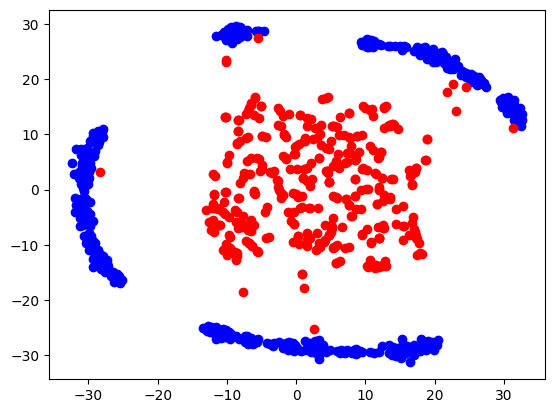

In [16]:
plt.scatter(train.query('is_good == 1')['embed_ax0'], train.query('is_good == 1')['embed_ax1'], color='blue')
plt.scatter(train.query('is_good == 0')['embed_ax0'], train.query('is_good == 0')['embed_ax1'], color='red')

##### ▶UMAP

C:\Users\ispec\AppData\Local\Temp\ipykernel_11808\3164109637.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x='axis0', y='axis1', hue=train['is_good'], data=train, palette=palette, alpha=0.5)


<AxesSubplot: xlabel='axis0', ylabel='axis1'>

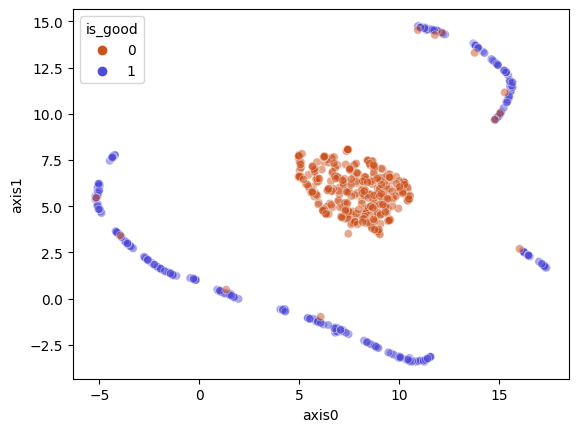

In [17]:
mapper = umap.UMAP(n_components=2, 
                n_neighbors=15,
                min_dist=0.1,
                metric = "euclidean"
                )
umap_result = mapper.fit_transform(train_nparray)

train['axis0'] = umap_result[:, 0:1]
train['axis1'] = umap_result[:, 1:2]

sns.scatterplot(x='axis0', y='axis1', hue=train['is_good'], data=train, palette=palette, alpha=0.5)

##### ▶SVM

In [50]:
from sklearn.svm import SVC
SVM_SEED = 1
TRAIN_COL_NAME = 'sampled_xy_vecs'
TEST_COL_NAME = 'is_good'

train_x = train[TRAIN_COL_NAME].to_numpy()
train_y = train[TEST_COL_NAME].to_numpy()

train_x = np.array([np.array(nparr) for nparr in train[TRAIN_COL_NAME].to_numpy()])
train_y = np.array([np.array(nparr) for nparr in train[TEST_COL_NAME].to_numpy()])
test_x = np.array([np.array(nparr) for nparr in test[TRAIN_COL_NAME].to_numpy()])
test_y = np.array([np.array(nparr) for nparr in test[TEST_COL_NAME].to_numpy()])

svm_model = SVC(kernel='rbf', gamma='auto', random_state=SVM_SEED)
svm_result = svm_model.fit(train_x, train_y)

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
svm_pred = svm_model.predict(test_x)
print(confusion_matrix(test_y, svm_pred))
print(classification_report(test_y, svm_pred))

[[100   0]
 [  0 100]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



##### ▶決定木

In [20]:
from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier(criterion = 'entropy', max_depth=3, random_state = 0)
dtc_model.fit(train_x, train_y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [21]:
dtc_pred = dtc_model.predict(test_x)

In [22]:
print(confusion_matrix(test_y, dtc_pred))
print(classification_report(test_y, dtc_pred))

[[ 47  53]
 [  0 100]]
              precision    recall  f1-score   support

           0       1.00      0.47      0.64       100
           1       0.65      1.00      0.79       100

    accuracy                           0.73       200
   macro avg       0.83      0.73      0.71       200
weighted avg       0.83      0.73      0.71       200



##### ▶ロジスティック回帰

In [23]:
from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression(penalty='none')
lg_model.fit(train_x, train_y)

c:\Users\ispec\MyWorkSpace\python\drawing_2024\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none')

In [24]:
lg_pred = lg_model.predict(test_x)
print(confusion_matrix(test_y, lg_pred))
print(classification_report(test_y, lg_pred))

[[65 35]
 [29 71]]
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       100
           1       0.67      0.71      0.69       100

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200



##### ▶k-NN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_x, train_y)
knn_pred = knn_model.predict(test_x)

print(confusion_matrix(test_y, knn_pred))
print(classification_report(test_y, knn_pred))

[[ 97   3]
 [  0 100]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       100
           1       0.97      1.00      0.99       100

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



##### データの可視化

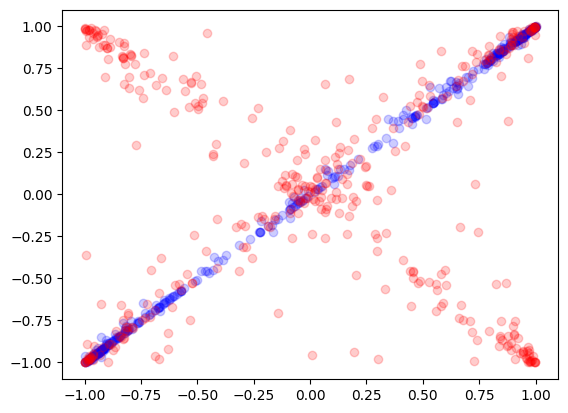

In [32]:
col_1 = 5
col_2 = col_1 + 1

for i in range(len(train_x)):
    # plt.xlim([-1, 1])
    # plt.ylim([-1, 1])
    
    if train_y[i] == 0:
        plt.scatter(train_x[:, col_1:col_1+1][i], train_x[:, col_2:col_2+1][i], color='red', alpha=0.2)
        pass
    else:
        plt.scatter(train_x[:, col_1:col_1+1][i], train_x[:, col_2:col_2+1][i], color='blue', alpha=0.2)
        pass

In [33]:
train_x[:, col_1:col_1+1][3]

array([0.17091686])

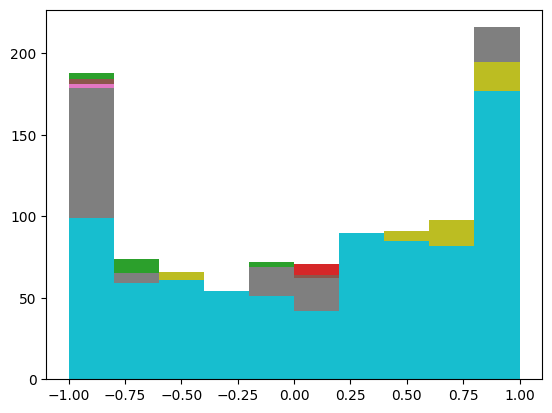

In [34]:
for i in range(SAMPLE_SIZE)[:]:
    plt.hist(train_x[:, i:i+1], bins=10)

##### ▶K-fold交差検証用のデータ分割関数

In [76]:
from sklearn.model_selection import KFold
data = pd.concat([good_500, ngood_500], axis=0).reset_index()

k = 5
kf = KFold(n_splits=k)

# ただのK-fold
for train_index, test_index in kf.split(data):
    train = pd.DataFrame([row for i, row in data.iterrows() if i in train_index])
    test = pd.DataFrame([row for i, row in data.iterrows() if i in test_index])
    
# 層化抽出法を適用したK-fold
def StratifiedKFold():
    return

##### ▶学習曲線の可視化

In [74]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

train_sizes = np.arange(100, 801, 100)

train_sizes, train_scores, test_scores = learning_curve(estimator=svm_model,
                                                        X=train_x, 
                                                        y=train_y,
                                                        cv=5
                                                        n_jobs=1
                                                        )

train_scores, valid_scores = validation_curve(estimator=svm_model,
                                              X=train_x, 
                                              y=train_y,
                                              cv=5, 
                                              n_jobs=1
                                              )